In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import math
from sklearn.metrics import mean_squared_error
# No module named 'tensorflow'

"""
Gas turbine (GT1) 
Generator Watts Max Selected {Avg}
Exhaust Temp Median Corrected By Average {Avg}
Compressor Inlet Temperature {Avg}
IGV angle in deg {Avg} 
Compressor Discharge Press Max Select {Avg}
Compressor Discharge Temperature {Avg} 
"""
def start():
    return None

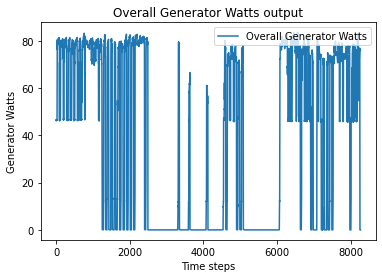

In [8]:
# It's time series dataset, we can only focus on the output: Generator Watts 
# one dependent Variable
filename = 'interview data.xlsx'
df = pd.read_excel(filename)
gen_max_wat = df['GT1 Generator Watts Max Selected {Avg}']

# plot the dataset
plt.plot(gen_max_wat,label = 'Overall Generator Watts')
plt.title('Overall Generator Watts output')
plt.xlabel('Time steps')
plt.ylabel('Generator Watts')
plt.legend(loc = 1)
plt.show()

In [9]:
# Data Normalization (0,1)
data = gen_max_wat.values
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range = (0, 1))
train_data = scaler.fit_transform(data)

In [10]:
# split into train and test sets
# The first 70% will be chose as training dataset, the last 30% will be chose as testing dataset.
train_size = int(len(train_data) * 0.7)
test_size = len(train_data) - train_size
train, test = train_data[0:train_size,:], train_data[train_size:len(train_data),:]

In [11]:
def create_dataset(dataset, look_back=3):
    datax, datay = [], []
    for i in range(len(dataset) - look_back - 1):
        tem = dataset[i:(i+look_back),0]
        datax.append(tem)
        datay.append(dataset[i+look_back,0])
    return np.array(datax), np.array(datay) # convert an array of values into a dataset matrix

In [12]:
# Phrased as a regression problem, the input variables are t, t-1, t-3, ... and the output variable is t+1
# Look_back: define the number of time step we look back
# look_back = 30
look_back = 30
# training dataset
train_x, train_y = create_dataset(train, look_back)
trainX = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
# testing dataset
test_x, test_y = create_dataset(test, look_back)
testX = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

In [13]:
# LSTM model will be a sequential model with multiple layers
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2)) # Dropout layer is added to avoid over-fitting
model.add(LSTM(units=30, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1)) #  single value in the output
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(trainX, train_y, epochs = 10, batch_size = 32) # increase epochs to increae accuracy
                                                         # in order to save time, I chose epochs = 10

Epoch 1/10
180/180 [==============================] - 6s 15ms/step - loss: 0.0345
Epoch 2/10
180/180 [==============================] - 3s 14ms/step - loss: 0.0149
Epoch 3/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0123
Epoch 4/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0103
Epoch 5/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0090
Epoch 6/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0082
Epoch 7/10
180/180 [==============================] - 3s 15ms/step - loss: 0.0074
Epoch 8/10
180/180 [==============================] - 3s 17ms/step - loss: 0.0067
Epoch 9/10
180/180 [==============================] - 3s 18ms/step - loss: 0.0062
Epoch 10/10
180/180 [==============================] - 3s 17ms/step - loss: 0.0060


In [14]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([test_y])

In [15]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.44 RMSE
Test Score: 5.68 RMSE


In [16]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(train_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(train_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_data)-1, :] = testPredict

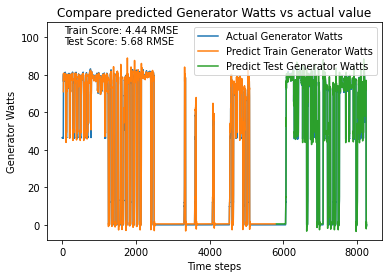

In [17]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(train_data),label = 'Actual Generator Watts')
plt.plot(trainPredictPlot, label = 'Predict Train Generator Watts')
plt.plot(testPredictPlot, label = 'Predict Test Generator Watts')
plt.title('Compare predicted Generator Watts vs actual value')
plt.text(0.05, 0.95, 'Train Score: %.2f RMSE' % (trainScore), transform=plt.gca().transAxes)
plt.text(0.05, 0.90, 'Test Score: %.2f RMSE' % (testScore), transform=plt.gca().transAxes)
plt.xlabel('Time steps')
plt.ylabel('Generator Watts')
plt.legend(loc = 1)
plt.ylim([-8, 108])
plt.show()

In [18]:
# As we can see, LSTM model can give very accurate prediction results with the time series input
# We can make a prediction based on the times series input. 
# Compare with TOB, we need to know enought previous dataset then we can make a prediction 
def name():
    return 'Shengbin Wang'
# Reference:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

In [19]:
input = np.array([0.0]*30)
class LSTM_model():
    def predict(input):
        input = np.array([input])
        tem = scaler.transform(input)
        test = model.predict(tem)
        resl = scaler.inverse_transform(test)
        return resl[0][0]

In [21]:
import pickle
pickle.dump(LSTM_model, open( "lstm_model", "wb" ))

In [26]:
input = [10.61340368,12.05516707,11.85658003,12.37894905,12.1762412,12.00315744,12.0743821,21.73378364,50.13263375
,49.34814217,47.67716428,53.17868441,47.7620959,70.95613885,72.49288691,72.39632316,72.66750671,72.64944651
         ,72.62355748
,72.71589641,76.15935361,78.6919531,78.8594456,78.77077693,78.60813514,78.49287136,78.31047626,78.14314049
,78.09783017,78.03647594]
tem1 = []
for item in input:
    item1 = np.array([np.array([item])])
    a = scaler.transform(item1)
    tem1.append(a[0][0])
test2 = np.array(tem1)
tem = np.array([test2])
test = model.predict(tem)
resl = scaler.inverse_transform(test)